In [2]:
# !pip install torch numpy matplotlib

In [3]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

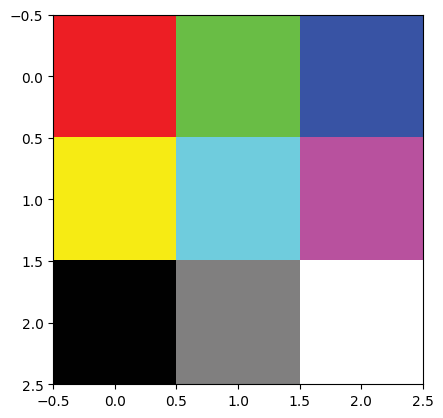

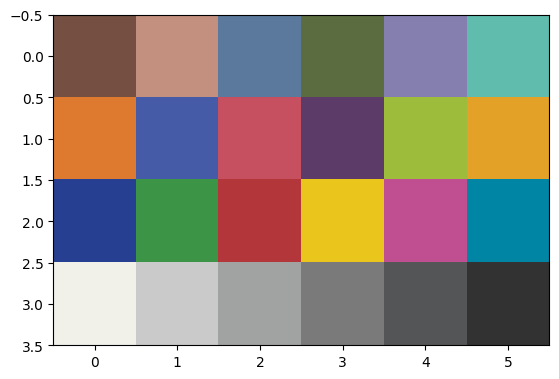

In [ ]:
# 推論データ
X =  np.array([[0.99, 0.01, 0.06],
               [0.02, 0.96, 0.07],
               [0.05, 0.09, 0.91],
               [0.95, 1.00, 0.04],
               [0.09, 0.97, 0.95],
               [0.99, 0.05, 0.94],
               [0.00, 0.00, 0.00],
               [0.52, 0.55, 0.55],
               [1.00, 1.00, 1.00],

               [0.11, 0.04, 0.00],
               [0.41, 0.41, 0.19],
               [0.10, 0.29, 0.27],
               [0.05, 0.15, 0.03],
               [0.19, 0.35, 0.35],
               [0.25, 0.85, 0.44],

               [0.55, 0.29, 0.05],
               [0.05, 0.18, 0.30],
               [0.43, 0.13, 0.11],
               [0.05, 0.01, 0.08],
               [0.34, 0.80, 0.14],
               [0.66, 0.60, 0.12],

               [0.05, 0.08, 0.21],
               [0.08, 0.39, 0.06],
               [0.28, 0.00, 0.00],
               [0.63, 0.84, 0.11],
               [0.35, 0.10, 0.18],
               [0.06, 0.39, 0.34],

               [0.90, 1.00, 0.87],
               [0.56, 0.94, 0.55],
               [0.29, 0.49, 0.28],
               [0.12, 0.19, 0.11],
               [0.03, 0.05, 0.03],
               [0.00, 0.00, 0.00]], dtype=np.float32)

img1 = cv2.resize(cv2.imread("img/reference_image1_cmyk_large.png", cv2.IMREAD_COLOR_RGB), (3,3), interpolation=cv2.INTER_NEAREST)
img2 = cv2.resize(cv2.imread("img/reference_image2_cmyk_large.png", cv2.IMREAD_COLOR_RGB), (6,4), interpolation=cv2.INTER_NEAREST)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

# 正解データ
Y = np.concatenate([img1.reshape([-1, 3])/255, img2.reshape([-1, 3])/255], axis=0).astype(np.float32)

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# モデル定義
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 3),
        )

    def forward(self, x):
        return self.model(x)

model = ColorNet()

# 損失関数（MSE）
criterion = nn.MSELoss()

# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

# L1正則化の係数
lambda_l1 = 1e-6

# 学習ループ
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_tensor)
    mse = criterion(outputs, Y_tensor)

    # --- L1 正則化-----------------------------
    l1 = torch.tensor(0.0, requires_grad=False)
    for name, p in model.named_parameters():
        if 'weight' in name:
            l1 = l1 + p.abs().sum()
    loss = mse + lambda_l1 * l1
    # -----------------------------------------

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}]  MSE: {mse.item():.6f}  L1: {l1.item():.2f}  Loss: {loss.item():.6f}')

with torch.no_grad():
    predictions = model(X_tensor)
    print("\n予測結果：")
    print(predictions.numpy())

def convert_to_cpp_array(tensor: torch.Tensor, name: str, dtype: str = "float"):
    flat = tensor.detach().numpy().flatten()
    array_str = f"{dtype} {name}[] = {{"
    array_str += ", ".join(map(str, flat))
    array_str += "};"
    return array_str

cpp_code = ""

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += convert_to_cpp_array(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_cpp_array(layer.bias,   f"bias_{layer_idx}") + "\n"
        layer_idx += 1

with open("model_parameters.h", "w") as f:
    f.write(cpp_code)

print("\nC++ 用のパラメータファイル (model_parameters.h) を作成しました。")


Epoch [0/50000]  MSE: 0.496675  L1: 28.28  Loss: 0.524958
Epoch [500/50000]  MSE: 0.021546  L1: 8.85  Loss: 0.030396
Epoch [1000/50000]  MSE: 0.021498  L1: 7.62  Loss: 0.029114
Epoch [1500/50000]  MSE: 0.021502  L1: 7.56  Loss: 0.029060
Epoch [2000/50000]  MSE: 0.021504  L1: 7.54  Loss: 0.029040
Epoch [2500/50000]  MSE: 0.021503  L1: 7.53  Loss: 0.029033
Epoch [3000/50000]  MSE: 0.021498  L1: 7.55  Loss: 0.029044
Epoch [3500/50000]  MSE: 0.021498  L1: 7.53  Loss: 0.029024
Epoch [4000/50000]  MSE: 0.021499  L1: 7.54  Loss: 0.029037
Epoch [4500/50000]  MSE: 0.021500  L1: 7.55  Loss: 0.029048
Epoch [5000/50000]  MSE: 0.021501  L1: 7.54  Loss: 0.029038
Epoch [5500/50000]  MSE: 0.021496  L1: 7.53  Loss: 0.029030
Epoch [6000/50000]  MSE: 0.021501  L1: 7.54  Loss: 0.029041
Epoch [6500/50000]  MSE: 0.021503  L1: 7.54  Loss: 0.029040
Epoch [7000/50000]  MSE: 0.021501  L1: 7.54  Loss: 0.029036
Epoch [7500/50000]  MSE: 0.021504  L1: 7.55  Loss: 0.029057
Epoch [8000/50000]  MSE: 0.021498  L1: 7.54